# **Assignment 14**
# **Disturbance Storm Time Index Prediction**

### **Data Analysis for Space Weather | Instructor: Prof Podladchikova | April, 2021**
### **by Victoria Krivova, Polina Starodumova**

The objective of this assignment is to learn how to model the evolution of the ring current index Dst in terms of solar wind parameters.  The Dst is a geomagnetic index which monitors the world wide magnetic storm level. It is constructed by averaging the horizontal component of the geomagnetic  field  from  mid-latitude  and  equatorial  magnetograms  from  all  over  the  world. Studies of geomagnetic storms are highly important for space weather applications. An advance warning  of high  geomagnetic  activity  can  minimize  hazards  and increase  operational  security of technological systems suchas satellites, pipelines, power systems and radio communications.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

In [62]:
import sys
sys.setrecursionlimit(10**6)

import scipy.stats as stats

**We are going to use hourly averaged solar wind data from  World Data Center Kyoto for year 2001.**  
**Units: southward component of IMF Bz - in nT, flow speed (solar wind velocity) V – km/sec, flow pressure P_dyn – nPa**

In [48]:
dst = pd.read_csv('omni_dst_2001.txt', header=None, delim_whitespace=True)
dst.columns = ['year', 'DOY', 'hour', 'Bz', 'V', 'P_dyn']
# convert it to more convenient format
dst.insert(0, 'date', pd.to_datetime(dst['year'].astype(str) + ' ' + dst['DOY'].astype(str) + ' ' + dst['hour'].astype(str), format='%Y %j %H'))
dst.sort_values(by='date', inplace=True)
dst.reset_index(inplace=True, drop=True)
Bz = np.array(dst.Bz)
V = np.array(dst.V)
P_dyn = np.array(dst.P_dyn)

dst.head()

,date,year,DOY,hour,Bz,V,P_dyn
0,2001-01-01 00:00:00,2001,1,0,-0.7,290.0,99.99
1,2001-01-01 01:00:00,2001,1,1,-1.2,292.0,99.99
2,2001-01-01 02:00:00,2001,1,2,-1.7,287.0,99.99
3,2001-01-01 03:00:00,2001,1,3,-1.7,286.0,99.99
4,2001-01-01 04:00:00,2001,1,4,-1.3,286.0,99.99


**Let's fill missed values (marked as several nines) by averaging 2 neighbours surrounding a group of invalid values:**

In [66]:
def sub_invalid_numbers_with_average(array, invalid):
    final_array = []
    is_in_invalid_range = False
    number_before_range = 0
    number_after_range = 0
    range_counter = 0
    for i in range(0, len(array)):
        if array[i] == invalid and not is_in_invalid_range:
            is_in_invalid_range = True
            range_counter += 1
            if i == 0:
                number_before_range = 0
            else:
                number_before_range = array[i-1]
        elif array[i] == invalid and is_in_invalid_range:
            range_counter += 1
        elif array[i] != invalid and is_in_invalid_range:
            is_in_invalid_range = False
            number_after_range = array[i]
            if i == len(array) - 1:
                for j in range(0, range_counter):
                    final_array.append(number_before_range)
                final_array.append(array[i])
                continue
            if number_before_range == 0:
                for j in range(0, range_counter):
                    final_array.append(number_after_range)
                final_array.append(array[i])
            else:
                for j in range(0, range_counter):
                    final_array.append((number_after_range + number_before_range) / 2)
                final_array.append(array[i])
            number_before_range = 0
            number_after_range = 0
            range_counter = 0
        else:
            final_array.append(array[i])
    for i in range(0, range_counter):
        final_array.append(number_before_range)
    return final_array

In [144]:
P_dyn = sub_invalid_numbers_with_average(P_dyn, 99.99)
V = sub_invalid_numbers_with_average(V, 9999.)
Bz = sub_invalid_numbers_with_average(Bz, 999.9)

**From the database let's also obtain true values of Dst index that we'll compare model predictions to. We need initial value of Dst for models operation as well:**

In [145]:
# no missed values here
true_dst = pd.read_csv('true_dst_2001.txt', header=None, delim_whitespace=True)
true_dst.columns = ['year', 'DOY', 'hour', 'Dst']
dst_value = np.array(true_dst.Dst)

**Our task is to predict Dst index 1 hour ahead using three models for Dst index evolution: AK1, UCB, AK2. Below we'll introduce special constants and some functions needed for the Dst calculation**

**Pressure corrected Dst index:**

In [73]:
def corr_dst(dst, P_dyn, b, c):
    return (dst - b * math.sqrt(P_dyn) + c)

In [93]:
# constans being used

b_ak1 = 8.74
c_ak1 = 11.5

b_ucb = 15.8
c_ucb = 20

b_ak2 = 7.26
c_ak2 = 11

**Solar wind parameter Q for three models:**

In [143]:
def Q_ak1(VBs, P_dyn):
    return -2.47*VBs
    
def Q_ucb(VBs, P_dyn):
    if VBs <= 0.5:
        return 0
    return -4.32 * (VBs - 0.5) * P_dyn ** 1/3
    
def Q_ak2(VBs, P_dyn):
    return -4.4 * (VBs - 0.5)

**Decay time constant, associated with the loss processes in the inner magnetosphere:**

In [142]:
def tau_ak1(VBs):
    return 17

def tau_ucb(VBs):
    if VBs <= 4:
        return 7.7
    return 3
    
def tau_ak2(VBs):
    return 2.4 * math.exp(9.74 / (4.69 + VBs))

**Driving solar wind parameter or so-called goeffectiveness indicator VBs:**

In [77]:
def VBs(V, Bz):
    if Bz >= 0:
        return 0
    return abs(V * Bz) / 1000 
    
# division as VBs is given in mV/m and V in km/s

**From Burton equation simple forward difference is derived and Dst is calculated recursively:**

In [78]:
def calc_dst(i, q_func, tau, b, c):
    if i == 1:
        return corr_dst(dst_values[0], P_dyn[0], b, c) * (1 - 1 / tau(VBs(V[0], Bz[0]))) + q_func(VBs(V[0], Bz[0]), P_dyn[0])
    return calc_dst(i-1, q_func, tau, b, c)*(1 - 1 / tau(VBs(V[i-1], Bz[i-1]))) + q_func(VBs(V[i-1], Bz[i-1]), P_dyn[i-1])

**Now let's obtain predictions for 3 models:**

In [98]:
# AK1
pred_dst = [] # array of predicted corrected Dst indexes
pred_dst.append(corr_dst(dst_values[0], P_dyn[0], b_ak1, c_ak1))

for i in range(1, len(Bz)):
    pred_dst_i = calc_dst(i, Q_ak1, tau_ak1, b_ak1, c_ak1)          
    pred_dst.append(pred_dst_i)
        

In [99]:
# convert corrected Dst to usual ones
dst_final_ak1 = []

for i in range(len(Bz)):
    dst_final_ak1.append(pred_dst[i] + b_ak1 * math.sqrt(P_dyn[i]) - c_ak1)   

In [100]:
# UCB
pred_dst = [] # array of predicted corrected Dst indexes
pred_dst.append(corr_dst(dst_values[0], P_dyn[0], b_ucb, c_ucb))

for i in range(1, len(Bz)):
    pred_dst_i = calc_dst(i, Q_ucb, tau_ucb, b_ucb, c_ucb)          
    pred_dst.append(pred_dst_i)
        
dst_final_ucb = []

for i in range(len(Bz)):
    dst_final_ucb.append(pred_dst[i] + b_ucb * math.sqrt(P_dyn[i]) - c_ucb)

In [101]:
# AK2
pred_dst = [] # array of predicted corrected Dst indexes
pred_dst.append(corr_dst(dst_values[0], P_dyn[0], b_ak2, c_ak2))

for i in range(1, len(Bz)):
    pred_dst_i = calc_dst(i, Q_ak2, tau_ak2, b_ak2, c_ak2)          
    pred_dst.append(pred_dst_i)
    
dst_final_ak2 = []

for i in range(len(Bz)):
    dst_final_ak2.append(pred_dst[i] + b_ak2 * math.sqrt(P_dyn[i]) - c_ak2)

**Plotting all obtained Dst-s to compare them with Kyoto Dst curve:**

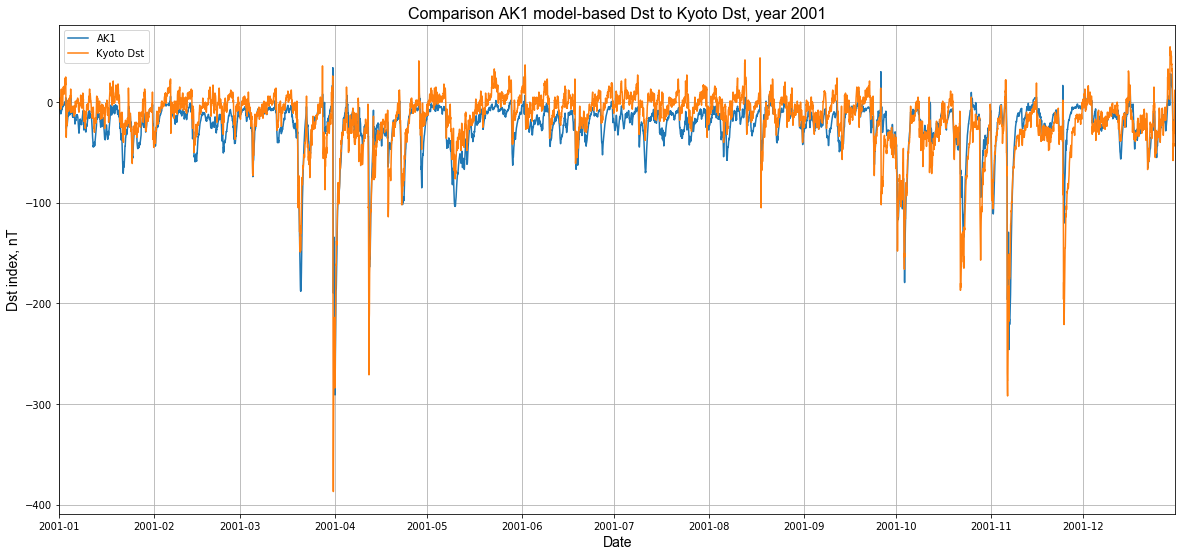

In [141]:
axis_font = {'fontname':'Arial', 'size':'14'}
title_font = {'fontname':'Arial', 'size':'16'} 

plt.figure(figsize=(20, 9))
plt.plot(dst.date, dst_final_ak1)

plt.plot(dst.date, dst_values)
plt.title("Comparison AK1 model-based Dst to Kyoto Dst, year 2001", **title_font)
plt.xlabel('Date', **axis_font)
plt.ylabel('Dst index, nT', **axis_font)
plt.xlim(pd.datetime(2001, 1,1), pd.datetime(2001,12,31))
plt.legend(['AK1','Kyoto Dst'])
plt.grid(True)

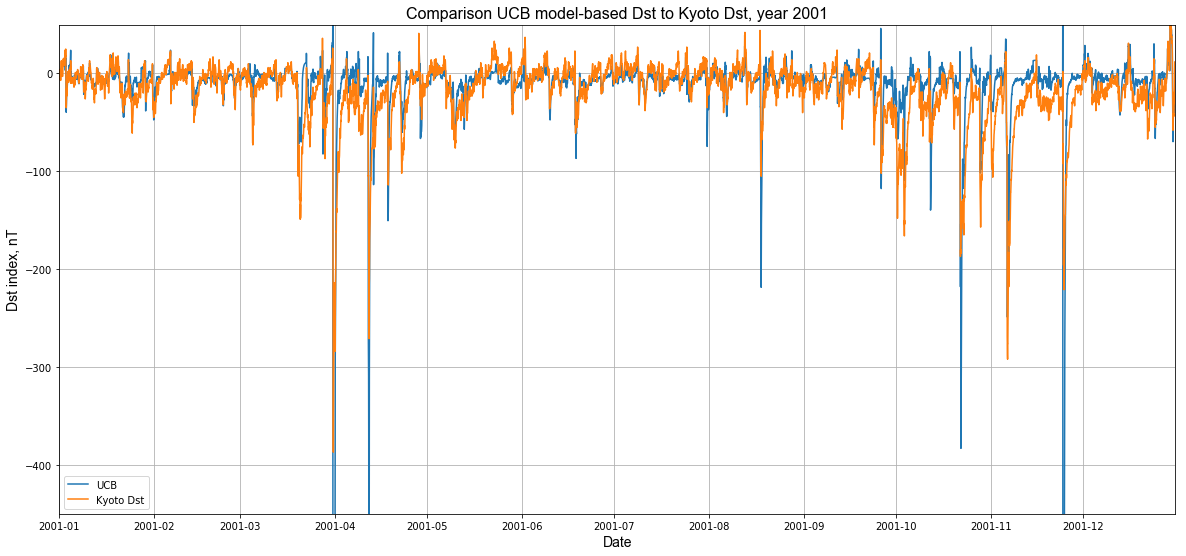

In [147]:
plt.figure(figsize=(20, 9))
plt.plot(dst.date, dst_final_ucb)
plt.plot(dst.date, dst_values)
plt.title("Comparison UCB model-based Dst to Kyoto Dst, year 2001", **title_font)
plt.xlabel('Date', **axis_font)
plt.ylabel('Dst index, nT', **axis_font)
plt.legend(['UCB','Kyoto Dst'])
plt.xlim(pd.datetime(2001, 1,1), pd.datetime(2001,12,31))
plt.ylim(-450, 50)
plt.grid(True)

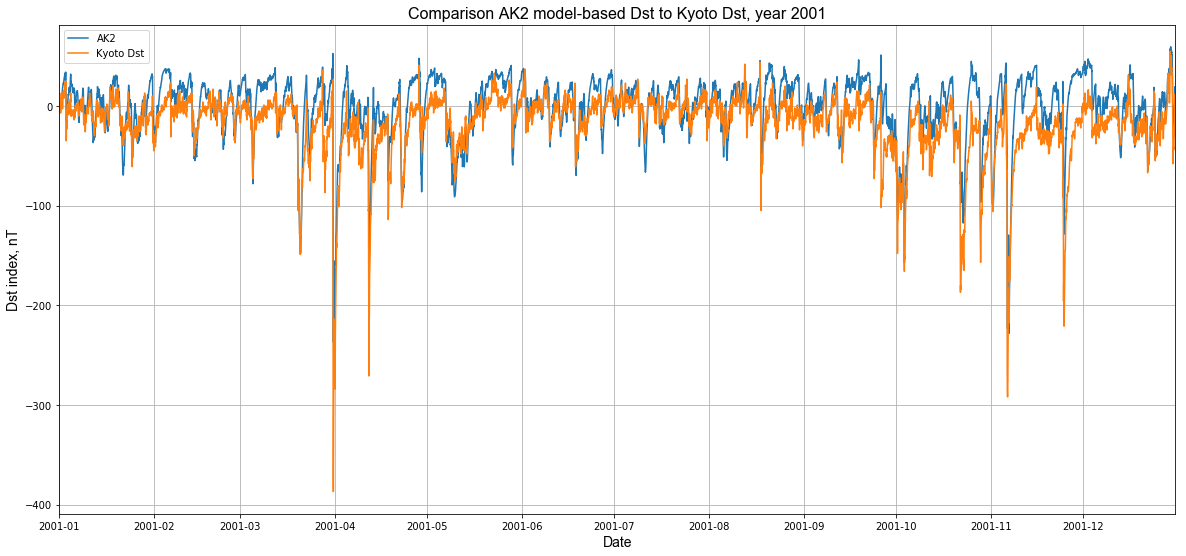

In [139]:
plt.figure(figsize=(20, 9))
plt.plot(dst.date, dst_final_ak2)
plt.plot(dst.date, dst_values)
plt.title("Comparison AK2 model-based Dst to Kyoto Dst, year 2001", **title_font)
plt.xlabel('Date', **axis_font)
plt.ylabel('Dst index, nT', **axis_font)
plt.xlim(pd.datetime(2001, 1,1), pd.datetime(2001,12,31))
plt.legend(['AK2','Kyoto Dst'])
plt.grid(True)

**Let's calculate errors of model estimations compared to Kyoto Dst values:**

In [123]:
errors_ak1 = dst_final_ak1 - dst_value
errors_ucb = dst_final_ucb - dst_value
errors_ak2 = dst_final_ak2 - dst_value   

**and visualize results in histogram, bin size is 5 nT:**

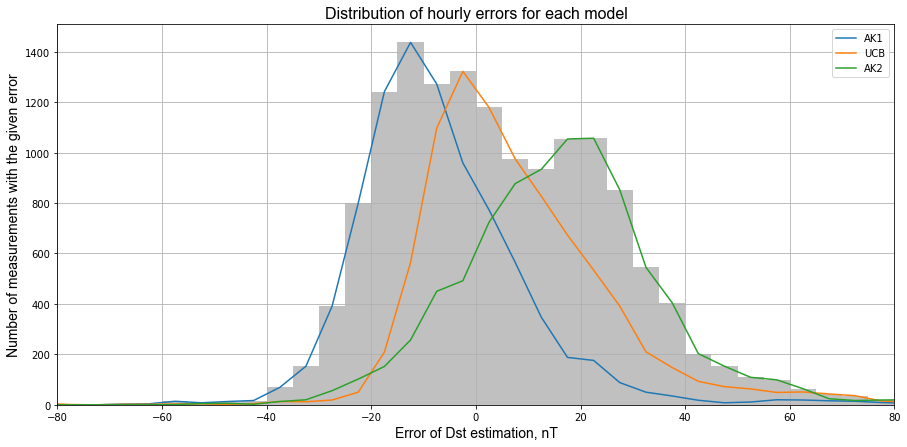

In [149]:
fig = plt.figure(figsize=(15,7))
bin_size = 5
min_edge = -100; max_edge = 100
N = int((max_edge-min_edge) / bin_size)
Nplus1 = N + 1
bin_list = np.linspace(min_edge, max_edge, Nplus1)

n1,x1,_ = plt.hist(errors_ak1, bin_list, color='silver')
n2,x2,_ = plt.hist(errors_ucb, bin_list, color='silver')
n3,x3,_ = plt.hist(errors_ak2, bin_list, color='silver')

bin_centers = 0.5*(x1[1:]+x1[:-1])
plt.plot(bin_centers,n1) 
bin_centers = 0.5*(x2[1:]+x2[:-1])
plt.plot(bin_centers,n2) 
bin_centers = 0.5*(x3[1:]+x3[:-1])
plt.plot(bin_centers,n3) 

plt.xlabel("Error of Dst estimation, nT", **axis_font)
plt.ylabel("Number of measurements with the given error", **axis_font)
plt.xlim(-80, 80)
plt.title('Distribution of hourly errors for each model', **title_font)
plt.legend(['AK1', 'UCB', 'AK2'])
plt.grid();

**Learning log:**

**Accurate prediction of Dst index is highly important as geomagnetic activities have significant effects on life and technology on Earth and its orbits. In this assignment we've worked with 3 models of Dst estimation based on Burton equation: AK1, UCB (Fenrich and Luhmann, 1998), AK2 (O’Brien and McPherron, 2000). Accuracy was assessed in comparison to Dst data by Kyoto World Data Center.  
According to plots and histogram, UCB provides the best estimation especially in moderately intense disturbances still it predicts too severe negative peaks. Opposite to that, AK2 tend to underestimate the strength of coming storms, what is actually worse.  
The problem we've faced is gaps in flow pressure data, quite often met. We've substituted them with nearby values, but still Dst correction bases on these values a lot, what can affect the results of estimation. And in case of UCB Q-equation includes this dynamic pressure contribution to energy transfer from the solar wind to the magnetosphere.   All three models have error distributions that are roughly Gaussian, but UCB is most zero-centered.  
Our conclusions differ from ones given in article discussed, what can be explained by the fact that we were considering quite large time interval with many data gaps. Models can behave differently if choose shorter time frame, more sophisticated way of filling missed values or initial Kyoto Dst index.**
